# Disaster Tweet Classification

Binary classification of disaster-related tweets using TF-IDF and machine learning.

### 1 - Notebook Overview

**Goal:** Predict whether a tweet is about a real disaster (1) or not (0), using the [Kaggle Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started) dataset of 7,613 labeled tweets.

**Pipeline:**

1. Load and inspect the dataset
2. Preprocess tweet text (lowercasing, removing URLs/mentions/special characters, stop word removal, lemmatization)
3. Vectorize text using TF-IDF
4. Train a Logistic Regression baseline model
5. Evaluate with accuracy, precision, recall, F1-score, and confusion matrix
6. Optional: hyperparameter tuning and cross-validation

**Dataset:** `train.csv` with columns `text` (tweet content) and `target` (1 = disaster, 0 = not disaster).

### 2 - Import Libraries

In [94]:
# Core Libraries
import re
import numpy as np
import pandas as pd

# Data
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Visualisations
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')      # Common words to filter out (the, is, at, ...)
nltk.download('wordnet')        # Lexical database for lemmatization
nltk.download('punkt_tab')      # Sentence/word tokenizer

[nltk_data] Downloading package stopwords to /Users/annie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/annie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/annie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### 3 - Data Loading & Inspection

In [95]:
# Import the training dataset
train_data = pd.read_csv("../data/train.csv")

# Check shape of the training dataset and view the first few rows
print(f"Shape of training dataset: {train_data.shape}")
train_data.head()

Shape of training dataset: (7613, 2)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


text      0
target    0
dtype: int64

target
0    0.57034
1    0.42966
Name: proportion, dtype: float64


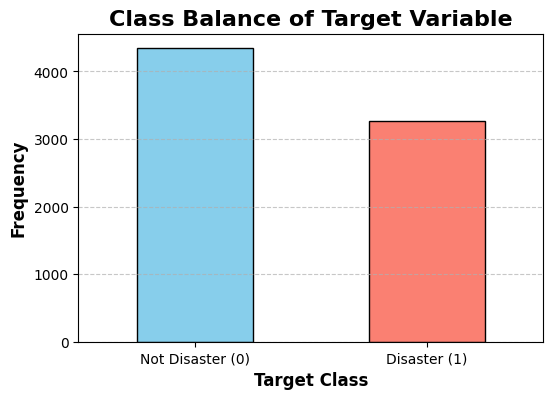

In [96]:
# Check for missing values and class balance
print(train_data.isnull().sum())
print()
print(train_data['target'].value_counts(normalize=True))

# Visualize class balance with labels 0 = not a disaster, 1 = disaster
plt.figure(figsize=(6, 4))
train_data['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Target Class', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Class Balance of Target Variable', fontsize=16, fontweight='bold')
plt.xticks(ticks=[0, 1], labels=['Not Disaster (0)', 'Disaster (1)'], rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Export visualization and show
plt.savefig('../visualizations/class_balance.png', dpi=300, bbox_inches='tight')
plt.show()

The dataset has no missing values in the `text` or `target` columns. The class distribution is not balanced:

- roughly 57% of tweets are non-disaster and
- 43% are disaster.

This is a mild imbalance, but it could affect the model's ability to correctly identify disaster tweets (recall for the minority class). This is something to keep in mind during evaluation, where accuracy alone may not tell the full story.

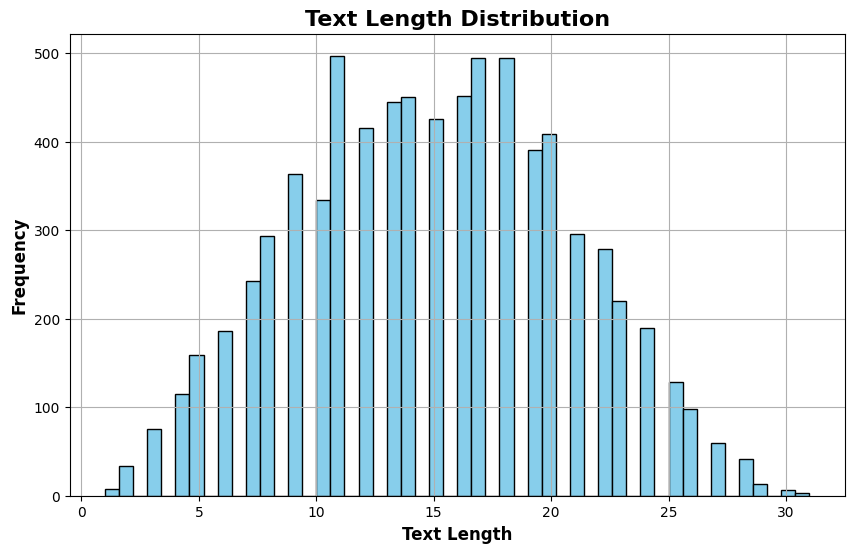

In [97]:
# Review length distribution
train_data['text_length'] = train_data['text'].apply(lambda x: len(x.split()))

# Plot the distribution of text lengths
plt.figure(figsize=(10, 6))
train_data['text_length'].hist(bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Text Length', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Text Length Distribution', fontsize=16, fontweight='bold')

# Export visualization and show
plt.savefig('../visualizations/text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Most tweets are between 5 and 25 words long, which is typical for social media text. The short length means each word carries more weight. There is little redundancy for the model to rely on. This reinforces why preprocessing choices (such as which words to keep or remove) will matter more than they would in longer documents.

In [98]:
# Drop helper column used for inspection
train_data.drop(columns=['text_length'], inplace=True)

### 4 - Text Preprocessing

The tweets are preprocessed by defining a function called `preprocess_text` that performs the following:

1. Converts text to lowercase.
2. Removes URLs and @mentions.
3. Removes `#` symbol but keeps hashtag words.
4. Removes special characters and numbers.
5. Tokenizes into words.
6. Removes stop words.
7. Lemmatizes words.

In [99]:
# Initialise lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower() # Lowercase
    # Remove URLs, @mentions, hashtags (keep words), special characters, and numbers
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize, lemmatize, and remove stop words
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens
              if word not in stop_words]
    return ' '.join(tokens)

In [100]:
# Apply preprocessing to create cleaned_text column
train_data['cleaned_text'] = train_data['text'].apply(preprocess_text)

# Preview raw vs cleaned text
train_data[['text', 'cleaned_text']].head(10)

,text,cleaned_text
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake may allah forgive u
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are ...,resident asked shelter place notified officer ...
3,"13,000 people receive #wildfires evacuation or...",people receive wildfire evacuation order calif...
4,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfire pour...
5,#RockyFire Update => California Hwy. 20 closed...,rockyfire update california hwy closed directi...
6,#flood #disaster Heavy rain causes flash flood...,flood disaster heavy rain cause flash flooding...
7,I'm on top of the hill and I can see a fire in...,im top hill see fire wood
8,There's an emergency evacuation happening now ...,there emergency evacuation happening building ...
9,I'm afraid that the tornado is coming to our a...,im afraid tornado coming area


In [101]:
# Print one full example before and after preprocessing
idx = 5  # "RockyFire Update" tweet
print("BEFORE:")
print(train_data.loc[idx, 'text'])
print()
print("AFTER:")
print(train_data.loc[idx, 'cleaned_text'])

BEFORE:
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires

AFTER:
rockyfire update california hwy closed direction due lake county fire cafire wildfire


### 5 - Text Vectorization

Before vectorizing, the data is shuffled and split into training and test sets. Shuffling ensures the model doesn't learn from the order of the data, and the split is stratified to maintain the same class distribution in both sets, preventing skewed evaluation results. Splitting is done before fitting the TF-IDF vectorizer so that word importance scores are learned only from training data, preventing information leakage from the test set.

In [102]:
tweets = train_data['cleaned_text']
labels = train_data['target']

# Split into train (80%) and test (20%)
# train_test_split shuffles the data by default (shuffle=True)
# stratify ensures both sets maintain the same class distribution
X_train, X_test, y_train, y_test = train_test_split(
    tweets,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=train_data['target']
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 6090
Test size: 1523


TF-IDF (Term Frequency–Inverse Document Frequency) is then used to convert the cleaned text into numerical features. It scores each word based on how often it appears in a tweet relative to how common it is across all tweets, giving higher weight to distinctive words.

In [103]:
# Fit TF-IDF on training data, transform both sets
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF feature matrix: {X_train_tfidf.shape[1]} features")

TF-IDF feature matrix: 11708 features


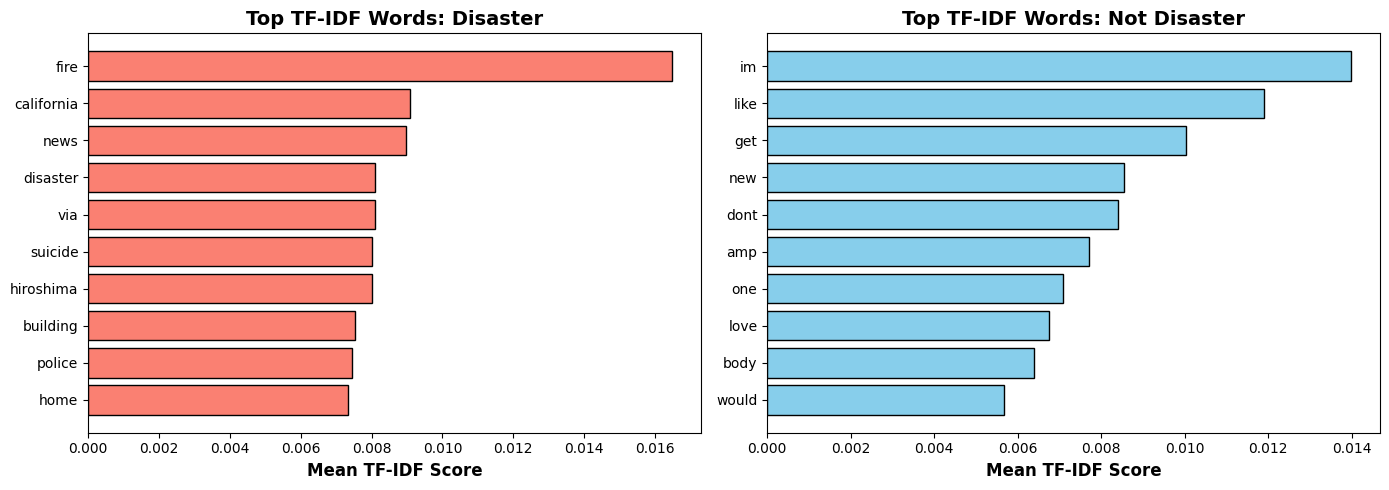

In [104]:
feature_names = np.array(tfidf.get_feature_names_out())

# Calculate mean TF-IDF score per word for each class
disaster_mask = (y_train == 1).values
not_disaster_mask = (y_train == 0).values

mean_tfidf_disaster = X_train_tfidf[disaster_mask].mean(axis=0).A1
mean_tfidf_not_disaster = X_train_tfidf[not_disaster_mask].mean(axis=0).A1

# Get top 10 words for each class
top_n = 10
top_disaster_idx = mean_tfidf_disaster.argsort()[-top_n:]
top_not_disaster_idx = mean_tfidf_not_disaster.argsort()[-top_n:]

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(feature_names[top_disaster_idx], mean_tfidf_disaster[top_disaster_idx], color='salmon', edgecolor='black')
axes[0].set_title('Top TF-IDF Words: Disaster', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Mean TF-IDF Score', fontsize=12, fontweight='bold')

axes[1].barh(feature_names[top_not_disaster_idx], mean_tfidf_not_disaster[top_not_disaster_idx], color='skyblue', edgecolor='black')
axes[1].set_title('Top TF-IDF Words: Not Disaster', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Mean TF-IDF Score', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/top_tfidf_words.png', dpi=300, bbox_inches='tight')
plt.show()

### 6 - Model Training

Two baseline models are trained on the TF-IDF vectors:

- **Logistic Regression:** Well suited for binary classification with high-dimensional sparse features. It estimates class probabilities and is easy to interpret.
- **Linear SVC (Support Vector Classifier):** Takes a different approach by finding the decision boundary that maximises the margin between classes, which can perform well on text classification tasks.

Both are fast to train and commonly used as baselines for text classification. Comparing them helps determine whether the choice of algorithm makes a meaningful difference on this dataset.

In [105]:
# Train Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=42)
logreg_model.fit(X_train_tfidf, y_train)

# Train Linear SVC model
svc_model = LinearSVC(max_iter=1000, random_state=42)
svc_model.fit(X_train_tfidf, y_train)

print("Both models trained successfully")

Both models trained successfully


### 7 - Model Evaluation

The model is evaluated on the held-out test set using a classification report and confusion matrix. The classification report provides precision, recall, and F1-score for each class, which is more informative than accuracy alone when classes are imbalanced. The confusion matrix shows where the model makes correct predictions and where it confuses one class for the other.

In [106]:
# Logistic Regression predictions
y_pred_logreg = logreg_model.predict(X_test_tfidf)

print("===== Logistic Regression =====")
print(classification_report(y_test, y_pred_logreg, target_names=['Not Disaster', 'Disaster']))

# Linear SVC predictions
y_pred_svc = svc_model.predict(X_test_tfidf)

print("===== Linear SVC =====")
print(classification_report(y_test, y_pred_svc, target_names=['Not Disaster', 'Disaster']))

===== Logistic Regression =====
              precision    recall  f1-score   support

Not Disaster       0.80      0.90      0.85       869
    Disaster       0.84      0.70      0.77       654

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523

===== Linear SVC =====
              precision    recall  f1-score   support

Not Disaster       0.81      0.84      0.83       869
    Disaster       0.78      0.74      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



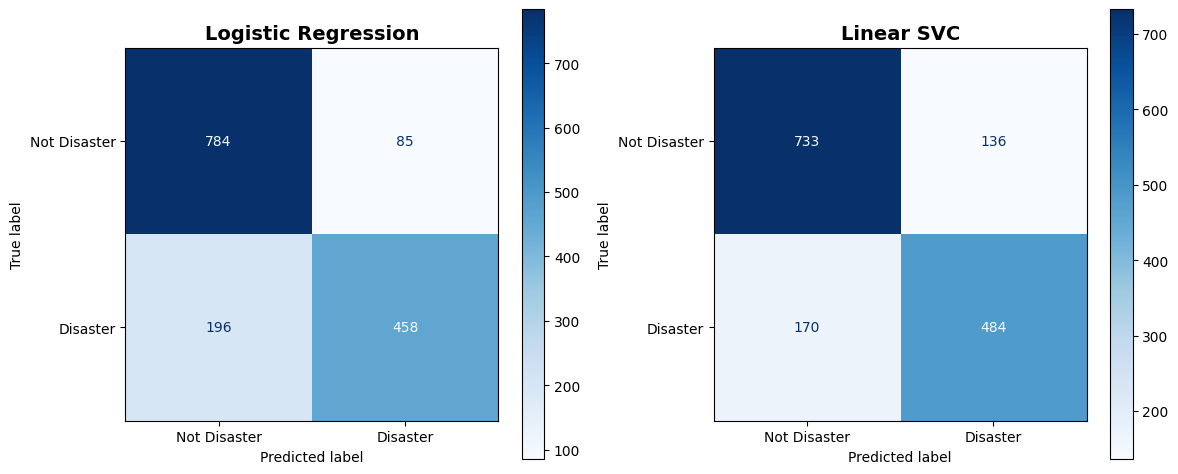

In [107]:
# Confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(cm_logreg, display_labels=['Not Disaster', 'Disaster'])
disp_logreg.plot(ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression', fontsize=14, fontweight='bold')

cm_svc = confusion_matrix(y_test, y_pred_svc)
disp_svc = ConfusionMatrixDisplay(cm_svc, display_labels=['Not Disaster', 'Disaster'])
disp_svc.plot(ax=axes[1], cmap='Blues')
axes[1].set_title('Linear SVC', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/confusion_matrix_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

Both models perform similarly, with Logistic Regression at 82% accuracy and Linear SVC at 80%. Logistic Regression has higher precision for disaster tweets (0.84 vs 0.78), meaning fewer false alarms, but lower recall (0.70 vs 0.74), meaning it misses more actual disasters. Linear SVC trades some precision for better recall, catching more disaster tweets at the cost of more false positives.

The F1 scores for the disaster class are close (0.77 vs 0.76), confirming that both linear models reach a similar performance ceiling with TF-IDF features. Logistic Regression is carried forward for hyperparameter tuning as it offers probability estimates and is well supported by sklearn's Pipeline and GridSearchCV.

### 8 - Hyperparameter Tuning

To improve on the baseline, an sklearn `Pipeline` is used to combine TF-IDF vectorization and Logistic Regression into a single workflow. This allows `GridSearchCV` to tune both vectorizer and model parameters together. The grid searches over `max_features` (vocabulary size), `ngram_range` (single words vs word pairs), and `C` (regularisation strength). Cross-validation (5-fold) is used to ensure the results are stable and not dependent on a single train-test split.

In [108]:
# Define pipeline
pipe = Pipeline(steps=[
    ('vec', TfidfVectorizer()),
    ('mod', LogisticRegression(max_iter=1000, random_state=42))
])

# Define parameter grid
param_grid = {
    'vec__max_features': [1000, 5000, 10000],
    'vec__ngram_range': [(1, 1), (1, 2)],
    'mod__C': [0.01, 0.1, 1, 10]
}

# Run grid search with 5-fold cross-validation
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'mod__C': [0.01, 0.1, ...], 'vec__max_features': [1000, 5000, ...], 'vec__ngram_range': [(1, ...), (1, ...)]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is

In [109]:
print(f"Best parameters: {grid.best_params_}")
print(f"Best cross-validation F1: {grid.best_score_:.4f}")

# Evaluate the tuned model on the test set
y_pred_tuned = grid.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred_tuned, target_names=['Not Disaster', 'Disaster']))

Best parameters: {'mod__C': 1, 'vec__max_features': 5000, 'vec__ngram_range': (1, 1)}
Best cross-validation F1: 0.7424
              precision    recall  f1-score   support

Not Disaster       0.81      0.90      0.86       869
    Disaster       0.85      0.72      0.78       654

    accuracy                           0.83      1523
   macro avg       0.83      0.81      0.82      1523
weighted avg       0.83      0.83      0.82      1523



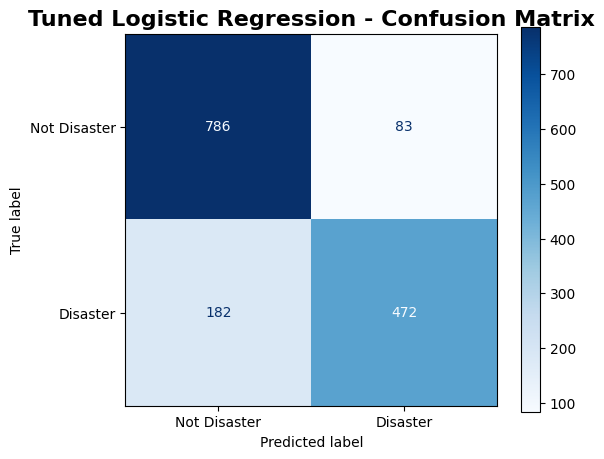

In [110]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_tuned)
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Disaster', 'Disaster'])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(ax=ax, cmap='Blues')
plt.title('Tuned Logistic Regression - Confusion Matrix', fontsize=16, fontweight='bold')

plt.savefig('../visualizations/confusion_matrix_tuned.png', dpi=300, bbox_inches='tight')
plt.show()

The tuned model shows a small improvement over the baseline, with accuracy rising from 82% to 83% and disaster F1 improving from 0.77 to 0.78. Recall for the disaster class increased from 0.70 to 0.72, meaning the model now catches slightly more actual disaster tweets. The best parameters (`C=1`, `max_features=5000`, `ngram_range=(1,1)`) suggest that the default regularisation strength was already near optimal, a capped vocabulary of 5,000 words removes noise from rare terms, and bigrams did not add value for this dataset.

The modest gain indicates that the baseline Logistic Regression was already a strong fit for this task. Further improvement would likely require a different approach, such as a more expressive model, richer text features, or additional training data, rather than further tuning of the same model.

### 9 - Limitations

- **Bag-of-words representation:** TF-IDF treats each word independently and ignores word order and context. Phrases like "not a disaster" lose their meaning when broken into individual tokens.
- **Sarcasm and ambiguity:** Tweets like "my mixtape is fire" or "this exam was a disaster" use disaster-related language figuratively. The model has no way to distinguish literal from metaphorical usage.
- **Small dataset:** With only 7,613 samples, the model has limited exposure to the variety of ways disasters are discussed, which may hurt generalisation.
- **Class imbalance:** The dataset is skewed toward non-disaster tweets (~57%), which contributes to the lower recall on the disaster class.
- **Preprocessing trade-offs:** Removing stop words and special characters discards information that could carry meaning in short, informal text like tweets (e.g. "not", "no", exclamation marks).